# Generate results comparing lines and geodesics between $q^{\text{ref}}$ and $q$

In [47]:
COL_TO_TEXT = {
    "diff_seq_per_time_vertex_diameter": "Mesh distance per vertex [% diameter]",
    "diff_seq_duration_per_time_and_vertex": "Time difference [secs] per mesh and vertex",
    "relative_diff_seq_duration": "Time difference per vertex [% line]",
    "noise_factor": "Deformation factor, Steps",
    "n_steps": "Number of steps",
    "n_vertices": "Number of vertices",
}

In [26]:
import numpy as np
import pandas as pd

We load the .csv that corresponds to the wandb Table downloaded from:

https://wandb.ai/bioshape-lab/line_vs_geodesic/table?workspace=user-ninamiolane

In [3]:
df = pd.read_csv("line_vs_geodesic.csv")
df.head()

,Name,State,Notes,User,Tags,Created,Runtime,Sweep,dataset_name,diameter,...,line_duration,linear_dist,linear_dist_per_vertex,linear_regression_duration,linear_regression_duration_per_vertex,relative_diff_dist,relative_diff_duration,relative_diff_seq_duration,relative_diff_seq_per_time_and_vertex,run_name
0,run_h9qtsump,running,-,ninamiolane,NaN,2023-07-04T12:59:52.000Z,271,NaN,synthetic,5400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,run_cp5kf8qp,finished,-,ninamiolane,NaN,2023-07-04T12:49:02.000Z,647,NaN,synthetic,5400,...,0.000240,1.167587e+05,720.732521,0.000128,7.873700e-07,-4.381025e+05,-1.123829e+06,-2.047536e+06,-2527.821746,run_cp5kf8qp
2,run_m55u2ci1,finished,-,ninamiolane,NaN,2023-07-04T12:45:28.000Z,212,NaN,synthetic,180,...,0.000320,1.862083e+03,44.335316,0.000112,2.662341e-06,-7.952702e+02,-2.289981e+05,-5.405396e+05,-1286.999136,run_m55u2ci1
3,run_r4idp2xs,finished,-,ninamiolane,NaN,2023-07-04T12:43:20.000Z,126,NaN,synthetic,180,...,0.000210,2.101606e+03,50.038250,0.000093,2.208210e-06,-7.184747e+02,-1.679656e+05,-4.634118e+05,-2206.722766,run_r4idp2xs
4,run_byfz4ssn,finished,-,ninamiolane,NaN,2023-07-04T11:58:55.000Z,2664,NaN,synthetic,162000,...,0.000426,7.321312e+06,11403.913372,0.000148,2.298771e-07,-2.465606e+08,-8.942921e+06,-3.100628e+06,-482.963844,run_byfz4ssn


The columns of the dataframe corresponding to the .csv are the variables that we have logged into wandb:

In [4]:
df.columns

Index(['Name', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime', 'Sweep',
       'dataset_name', 'diameter', 'n_faces', 'n_steps', 'n_times',
       'n_vertices', 'noise_factor', 'subdivisions', 'diff_dist',
       'diff_dist_per_vertex', 'diff_duration', 'diff_duration_per_vertex',
       'diff_seq_duration', 'diff_seq_duration_per_time_and_vertex',
       'diff_seq_per_time_and_vertex', 'diff_seq_per_time_vertex_diameter',
       'geodesic_dist', 'geodesic_dist_per_vertex', 'geodesic_duration',
       'geodesic_regression_duration',
       'geodesic_regression_duration_per_vertex', 'line_duration',
       'linear_dist', 'linear_dist_per_vertex', 'linear_regression_duration',
       'linear_regression_duration_per_vertex', 'relative_diff_dist',
       'relative_diff_duration', 'relative_diff_seq_duration',
       'relative_diff_seq_per_time_and_vertex', 'run_name'],
      dtype='object')

We can plot histograms of some of these variables to get intuition of their values.

Here, we plot how long is takes to compute one line between two meshes, per vertex. We see that it takes less than 1 microsecond per vertex, i.e. less than 5 seconds to compute a line between two meshes that has 5 mesh along the sequence and these meshes have 1000 vertices.

Average: 4.651403696484586e-07


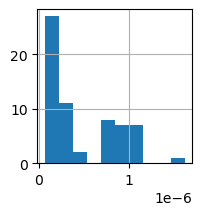

In [5]:
line_duration_per_time_vertex = df["line_duration"] / (df["n_vertices"] * df["n_times"])
print("Average:", line_duration_per_time_vertex.mean())
line_duration_per_time_vertex.hist(figsize=(2, 2));

We compare the time taken to compute a line versus a geodesic between two meshes.

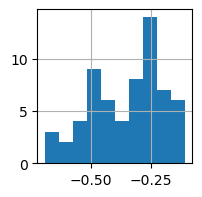

In [6]:
df["diff_seq_duration_per_time_and_vertex"].hist(figsize=(2, 2));

## Histograms

We write a function that can plot more sophisticated histograms, by grouping according to a given variable `by`.

In [35]:
import plotly.graph_objects as go


def hist_diff_seq_per_time_vertex_diameter_group(by="n_steps"):
    grouped_data = df.groupby(by)["diff_seq_per_time_vertex_diameter"]

    fig = go.Figure()

    for name, group in grouped_data:
        fig.add_trace(go.Histogram(x=group, opacity=0.5, name=f"{by} = {name}"))

    fig.update_layout(
        title=COL_TO_TEXT["diff_seq_per_time_vertex_diameter"],
        showlegend=True,
        width=600,  # Set the width of the figure to 500
        height=400, 
    )

    fig.show()

In [36]:
hist_diff_seq_per_time_vertex_diameter_group(by="n_steps")

In [37]:
hist_diff_seq_per_time_vertex_diameter_group(by="n_vertices")

In [38]:
hist_diff_seq_per_time_vertex_diameter_group(by="noise_factor")

## Scatter plots

We write code to generate the main plot for the corresponding section of the paper.

In [55]:
import plotly.express as px
import plotly.io as pio

fontsize = 15

def diff_scatter_grouped(
    colored_by="noise_factor",
    marked_by="n_steps",
    diff_seq="relative_diff_seq_duration",
):
    x = df["diff_seq_per_time_vertex_diameter"] * 100
    y = np.abs(df[diff_seq]) / df["n_vertices"]
    value_to_symbol = dict(zip(df[marked_by].unique(), ["square", "x", "cross"]))

    fig = px.scatter(
        df,
        x=x,
        y=y,
        color=[str(c) for c in df[colored_by].values],
        color_discrete_sequence=px.colors.qualitative.Dark24,  # D3 #Dark24 # Pastel
        symbol=[s for s in df[marked_by].values],
        symbol_map=value_to_symbol,
    )

    fig.update_layout(
        xaxis_title=dict(
            text=COL_TO_TEXT["diff_seq_per_time_vertex_diameter"],
            font=dict(family="CMU", size=fontsize),
        ),
        yaxis_title=dict(text=COL_TO_TEXT[diff_seq], font=dict(family="CMU", size=fontsize)),
        title_font=dict(family="CMU", size=fontsize),
        xaxis=dict(tickfont=dict(family="CMU", size=fontsize)),
        yaxis=dict(tickfont=dict(family="CMU", size=fontsize)),
        legend=dict(font=dict(family="CMU", size=fontsize), title=COL_TO_TEXT[colored_by]),
        width=650,
        height=370,
    )

    fig.update_traces(marker=dict(size=9, opacity=0.9))
    pio.write_image(fig, f"line_vs_geodesic_colored_by_{colored_by}.svg")
    fig.show()

In [44]:
diff_scatter_grouped(colored_by="noise_factor", marked_by="n_steps")

In [56]:
diff_scatter_grouped(colored_by="n_vertices", marked_by="n_steps")